In [43]:
'''Predicting Mortality across Germany wih different AI Methods
'''

import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
import dbf
from pygam import GAM, s, f, LinearGAM
import xgboost
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [2]:
# Set the working directory
os.chdir("N:/WG_ENRI/20_projects/Noise2NAKO/04_data/grid_prediction/3_output")
grid_path = "N:/PROJECTS/ENVGEO_DB/1_GIS_data_orig/2_administrative_units/BKG/INSPIRE_geogitter/DE_Grid_ETRS89-LAEA/data/DE_Grid_ETRS89-LAEA_5km.gpkg"

In [3]:
# Read training and test data
data_training = pd.read_csv('Prediction/Reduced_data_only_mean/Reduced_data_only_mean_minmax_scaled_Training_data.csv', sep=',')
data_test = pd.read_csv('Prediction/Reduced_data_only_mean/Reduced_data_only_mean_minmax_scaled_Test_data.csv', sep=',')

In [4]:
# distinguish between response and input variables and make training and test data 
# remove unnecessary features 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'

output_variable = 'cvd_mortality_17'
output_path = 'CVD Mortality Rate 2017_allExposures_XY/Reduced_data_only_mean/2_minmax_scaled_data'

# output_variable = 'ks_Mortality_17'
# output_path = 'Total Mortality Rate 2017 incl XY'

output_path = '../5_results/' + output_path + '/'
coord = True

y = data_training[output_variable]
if coord:
    X = data_training.drop([output_variable, 'id'], axis = 1)   
else:
    X = data_training.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)
    
pred_y = data_test[output_variable]
if coord:
    pred_X = data_test.drop([output_variable, 'id'], axis = 1)
else:
    pred_X = data_test.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Prediction

In [5]:
def Prediction(method, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable, output_path, data_training, data_test, grid_5km_shp):
    
    '''Prediction Function'''
    
    if method == 'LR':
        model = linear_model.LinearRegression().fit(X_train, y_train)
    elif method == 'LR_Ridge':
        model = linear_model.RidgeCV(cv = 5).fit(X_train, y_train)
    elif method == 'LR_Lasso':
        model = linear_model.LassoCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'LR_Elastic':
        model = linear_model.ElasticNetCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'GAM':
        model = GAM().fit(X_train, y_train)
    elif method == 'RF':
        model = RandomForestRegressor(n_estimators= 10, max_depth= 10, random_state= 0, max_features='sqrt').fit(X_train, y_train)
    elif method == 'AdaB':
        model = AdaBoostRegressor(n_estimators= 10, random_state=0).fit(X_train, y_train)
    else:
        model = xgboost.XGBRegressor().fit(X_train, y_train)
    
    print(method + ' is running ... ')
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred = model.predict(pred_X)
    y_pred = pd.DataFrame(y_pred, columns = [output_variable])

    result = {'Method': method, 'MSE_train': mean_squared_error(y_train, y_pred_train),
                            'MAE_train': mean_absolute_error(y_train, y_pred_train), 'R_2_train': r2_score(y_train, y_pred_train),
                           'MSE_val': mean_squared_error(y_test, y_pred_test), 'MAE_val': mean_absolute_error(y_test, y_pred_test),
                           'R_2_val': r2_score(y_test, y_pred_test), 'MSE_pred': mean_squared_error(pred_y, y_pred), 'MAE_pred': mean_absolute_error(pred_y, y_pred),
                           'R_2_pred': r2_score(pred_y, y_pred)}
    
#     Merge dataframes to make the final output dataset 
    data_result= pd.DataFrame()
    data_result = data_result.append(data_training)
    data_result = data_result.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(y_pred)],axis=1))
    data_result = data_result[['id', output_variable]]
    data_result.to_csv((output_path + method + '/prediction_result_' + method + '.csv'), sep=',', index=False)
    
#     Merge dataframes to make the Ground Truth
    GT = pd.DataFrame()
    GT = GT.append(data_training)
    GT = GT.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(pred_y)],axis=1))
    GT = GT[['id', output_variable]]
    GT.to_csv((output_path + 'GT/GT.csv'), sep=',', index=False)   
    
#     Make the difference output
    data_diff_result= pd.DataFrame()
    data_diff_result = data_diff_result.append(data_training)
    data_diff_result[output_variable] = 0
    pred_variable = 'pred'+output_variable
    data_test = pd.concat([data_test, y_pred.rename(columns={output_variable: pred_variable})], axis=1)
    data_test[output_variable] = data_test[output_variable] - data_test[pred_variable]
    data_diff_result = data_diff_result.append(data_test.drop([pred_variable], axis = 1))
    data_diff_result = data_diff_result[['id', output_variable]]
    data_diff_result.to_csv((output_path + 'diff_' + method + '/prediction_result_diff_' + method + '.csv'), sep=',', index=False)
    
#     Make shp files
    merged_data = grid_5km_shp.merge(data_result, left_on="id", right_on="id")
#     merged_data_GT = grid_5km_shp.merge(GT, left_on="id", right_on="id")
    merged_data_diff = grid_5km_shp.merge(data_diff_result, left_on="id", right_on="id")
#     save the GeoDataFrame
    merged_data.to_file(driver = 'ESRI Shapefile', filename= output_path + method + '/' + method + '_shape.shp')
#     merged_data.to_file(driver = 'ESRI Shapefile', filename= output_path + 'GT/GT_shape.shp')
    merged_data_diff.to_file(driver = 'ESRI Shapefile', filename= output_path + 'diff_'+ method + '/diff_' + method + '_shape.shp')
    
    return result, y_pred

### Prediction with different methods

In [6]:
result = pd.DataFrame(columns=['Method', 'MSE_train', 'MAE_train', 'R_2_train', 'MSE_val', 'MAE_val', 'R_2_val', 'MSE_pred', 'MAE_pred', 'R_2_pred'])
methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
preds = pd.DataFrame()
preds['GT'] = pred_y

grid_5km_shp = gpd.read_file(grid_path)

for i in methods:
    ToAppend, y_pred = Prediction(i, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable,
                                 output_path, data_training, data_test, grid_5km_shp)
    print(i + ' is done!\n')
    result = result.append(ToAppend, ignore_index=True)
    preds[i] = y_pred
    
result.to_csv(output_path + 'PredictionTask_results_allMethods.csv', index=False, sep=',')
result.round(decimals=3).to_csv(output_path + 'PredictionTask_results_allMethods_round.csv', index=False, sep=',')

result

LR is running ... 
LR is done!

LR_Ridge is running ... 
LR_Ridge is done!

LR_Lasso is running ... 
LR_Lasso is done!

LR_Elastic is running ... 
LR_Elastic is done!

GAM is running ... 
GAM is done!

RF is running ... 
RF is done!

AdaB is running ... 
AdaB is done!

XGBoost is running ... 
XGBoost is done!



,Method,MSE_train,MAE_train,R_2_train,MSE_val,MAE_val,R_2_val,MSE_pred,MAE_pred,R_2_pred
0,LR,3.002938e-03,0.039231,0.910074,0.002288,0.035559,0.929636,0.016765,0.095789,0.480139
1,LR_Ridge,3.023025e-03,0.039227,0.909473,0.002341,0.035819,0.928009,0.017229,0.097727,0.465760
2,LR_Lasso,3.015575e-03,0.039315,0.909696,0.002275,0.035493,0.930018,0.017030,0.096676,0.471933
3,LR_Elastic,3.022224e-03,0.039321,0.909497,0.002291,0.035559,0.929522,0.017142,0.097162,0.468452
4,GAM,2.136844e-04,0.010026,0.993601,0.000617,0.015843,0.981022,0.013069,0.089356,0.594735
5,RF,2.715166e-04,0.007860,0.991869,0.000660,0.013351,0.979694,0.014021,0.088017,0.565239
6,AdaB,1.551540e-03,0.027706,0.953538,0.002081,0.030742,0.935998,0.015088,0.094725,0.532151
7,XGBoost,6.121423e-07,0.000512,0.999982,0.000575,0.010384,0.982302,0.010882,0.077241,0.662548


In [7]:
preds

,GT,LR,LR_Ridge,LR_Lasso,LR_Elastic,GAM,RF,AdaB,XGBoost
0,0.267857,0.246685,0.242984,0.239786,0.238952,0.186163,0.165978,0.195954,0.217990
1,0.267857,0.264409,0.259229,0.256344,0.255102,0.187015,0.177760,0.195954,0.216658
2,0.267857,0.254699,0.249586,0.248147,0.247024,0.160837,0.181712,0.195954,0.217927
3,0.267857,0.265728,0.259762,0.258740,0.257352,0.142135,0.181712,0.195954,0.218014
4,0.267857,0.263142,0.256803,0.256775,0.255235,0.138209,0.177760,0.195954,0.217536
...,...,...,...,...,...,...,...,...,...
13840,0.303571,0.334295,0.337053,0.329114,0.329861,0.481066,0.326930,0.494380,0.445370
13841,0.303571,0.321301,0.323542,0.317693,0.318325,0.480982,0.331735,0.494380,0.448091
13842,0.303571,0.315390,0.318156,0.311543,0.312339,0.463797,0.333320,0.494380,0.444930
13843,0.303571,0.356012,0.357357,0.349467,0.349847,0.491126,0.332864,0.494380,0.448700


### Make maps

In [8]:
# def single_map_plot(output_path, method, show_map = False):
    
#     data_shp = gpd.read_file(output_path + method + '/' + method + '_shape.shp')
#     fig, ax = plt.subplots(1, 1, figsize=(10,15))
#     data_shp.plot(column='cvd_mortal', ax = ax, legend = True, legend_kwds={'loc': 'lower right'}, cmap = plt.cm.get_cmap('magma_r'), scheme='user_defined', classification_kwds={'bins':[3, 4, 5, 6, 8, 10]})
#     ax.set_axis_off()
#     ax.set_title(method, fontsize = 20)
#     plt.savefig(output_path + method + '/' + method + '_plot')
#     if (show_map == True):
#         plt.show()

In [9]:
# for i in methods:
#     single_map_plot(output_path, i, False)

In [49]:
def all_maps_plot(output_path, methods, number_of_columns, color_map = 'YlGn', file_name = 'all_methods_maps', bins = None, output_var = None):
           
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known
    Tot = len(methods)
    Cols = number_of_columns

    # Compute Rows required
    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index
    Position = range(1,Tot + 1)
    
    # Set the size of the figure
    fig_size_width = 5 * min(number_of_columns, len(methods))
    fig_size_heigth = 7 * np.ceil((len(methods) / number_of_columns))
    fig = plt.figure(1, figsize=(fig_size_width, fig_size_heigth))
    first_plot = 1
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    for k in range(Tot):
        
        data_shp = gpd.read_file(output_path + methods[k] + '/' + methods[k] + '_shape.shp')
        
        # if not defined, set the output variable to group the maps by
        if not output_var:
            for i in data_shp.columns:
                if 'mortal' in i:
                    output_var = i
                    
        # add every single subplot to the figure with a for loop
        ax = fig.add_subplot(Rows,Cols,Position[k])
        
        if (first_plot == 1 and bins): 
            data_shp.plot(column = output_var, ax = ax, legend = True, legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (0, 1)}, cmap = plt.cm.get_cmap(color_map), scheme='user_defined', classification_kwds={'bins': bins})
            first_plot = 2
        elif (first_plot == 1 and not bins):
            first_plot = 2
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            data_shp.plot(column = output_var, ax = ax, legend = True, cax = cax, cmap = plt.cm.get_cmap(color_map))
        elif(first_plot != 1 and bins):
            data_shp.plot(column = output_var, ax = ax, cmap = plt.cm.get_cmap(color_map), scheme='user_defined', classification_kwds={'bins':bins})
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            data_shp.plot(column = output_var, ax = ax, cax = cax, legend = True, cmap = plt.cm.get_cmap(color_map))
            
        ax.set_axis_off()
        ax.set_title(methods[k] , fontsize= 16)
    
    plt.savefig(output_path + file_name)
    plt.show()

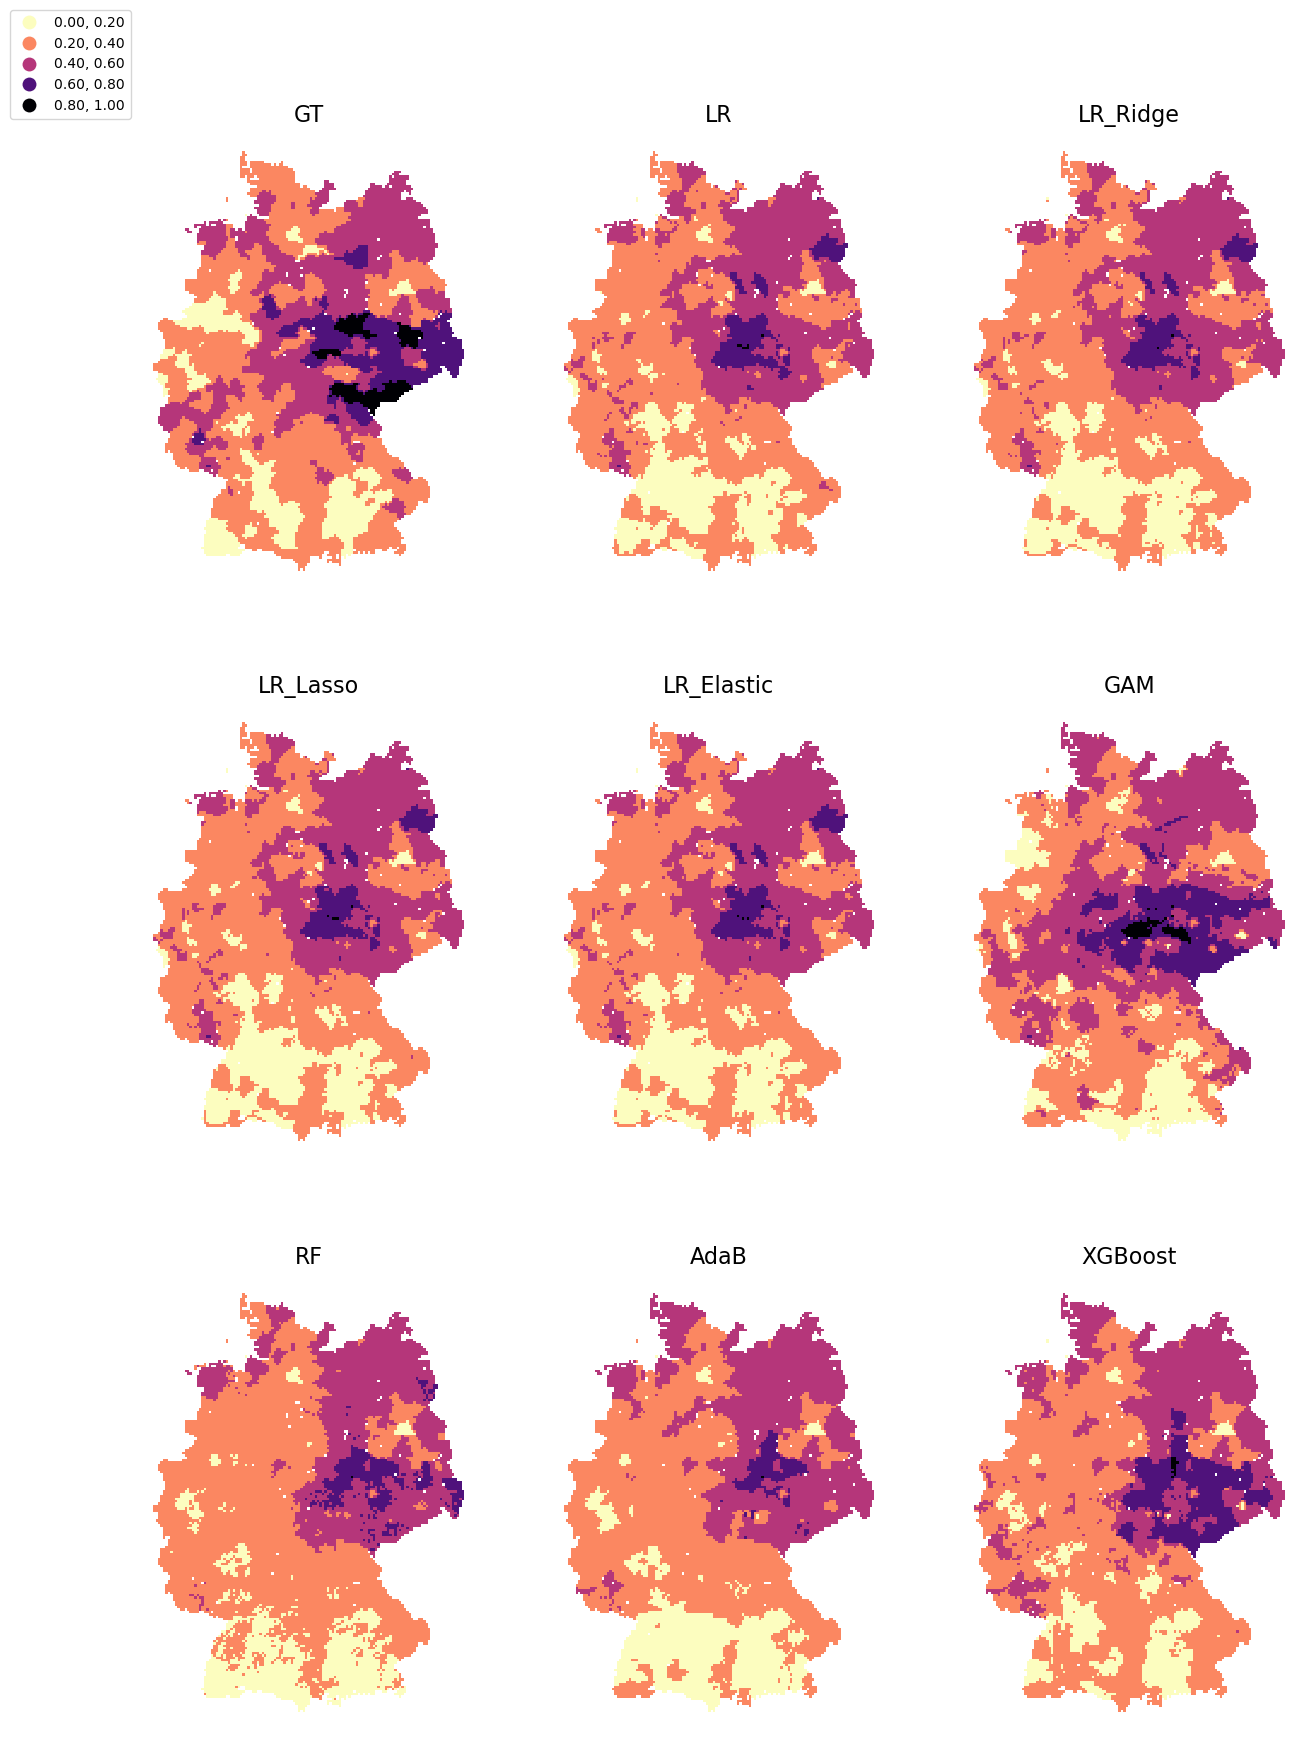

In [48]:
GT = pd.read_csv(output_path + 'GT/GT.csv', sep=',')
merged_data_GT = grid_5km_shp.merge(GT, left_on="id", right_on="id")
merged_data_GT.to_file(driver = 'ESRI Shapefile', filename= output_path + 'GT/GT_shape.shp')

to_plot = ['GT', 'LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
all_maps_plot(output_path, to_plot, 3, color_map= 'magma_r', file_name= 'Plots/all_methods_maps', bins= [0.2, 0.4, 0.6, 0.8, 1], output_var='cvd_mortal')

In [ ]:
methods_to_plot = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
for i in range(len(methods_to_plot)):
    methods_to_plot[i] = 'diff_' + methods_to_plot[i]
all_maps_plot(output_path, methods_to_plot, 4, color_map= 'bwr', file_name= 'Plots/diff_all_methods_maps', bins = [-0.25, 0, 0.25, 0.5], output_var='cvd_mortal')

### Make performance correlation plots

In [36]:
# plt.figure()
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(preds, corner=True, kind="reg", plot_kws={'line_kws':{'color':'red'}})
# plt.savefig(output_path + 'Plots/Performance_correlation')

In [37]:
# correlation_matrix = preds.corr(method='spearman')
# upper_corr_matrix = np.tril(correlation_matrix)
# plt.figure()
# sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Reds', mask = upper_corr_matrix )
# plt.savefig(output_path + 'Plots/Performance_correlation_Heatmap')

In [38]:
def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

<Figure size 432x288 with 0 Axes>

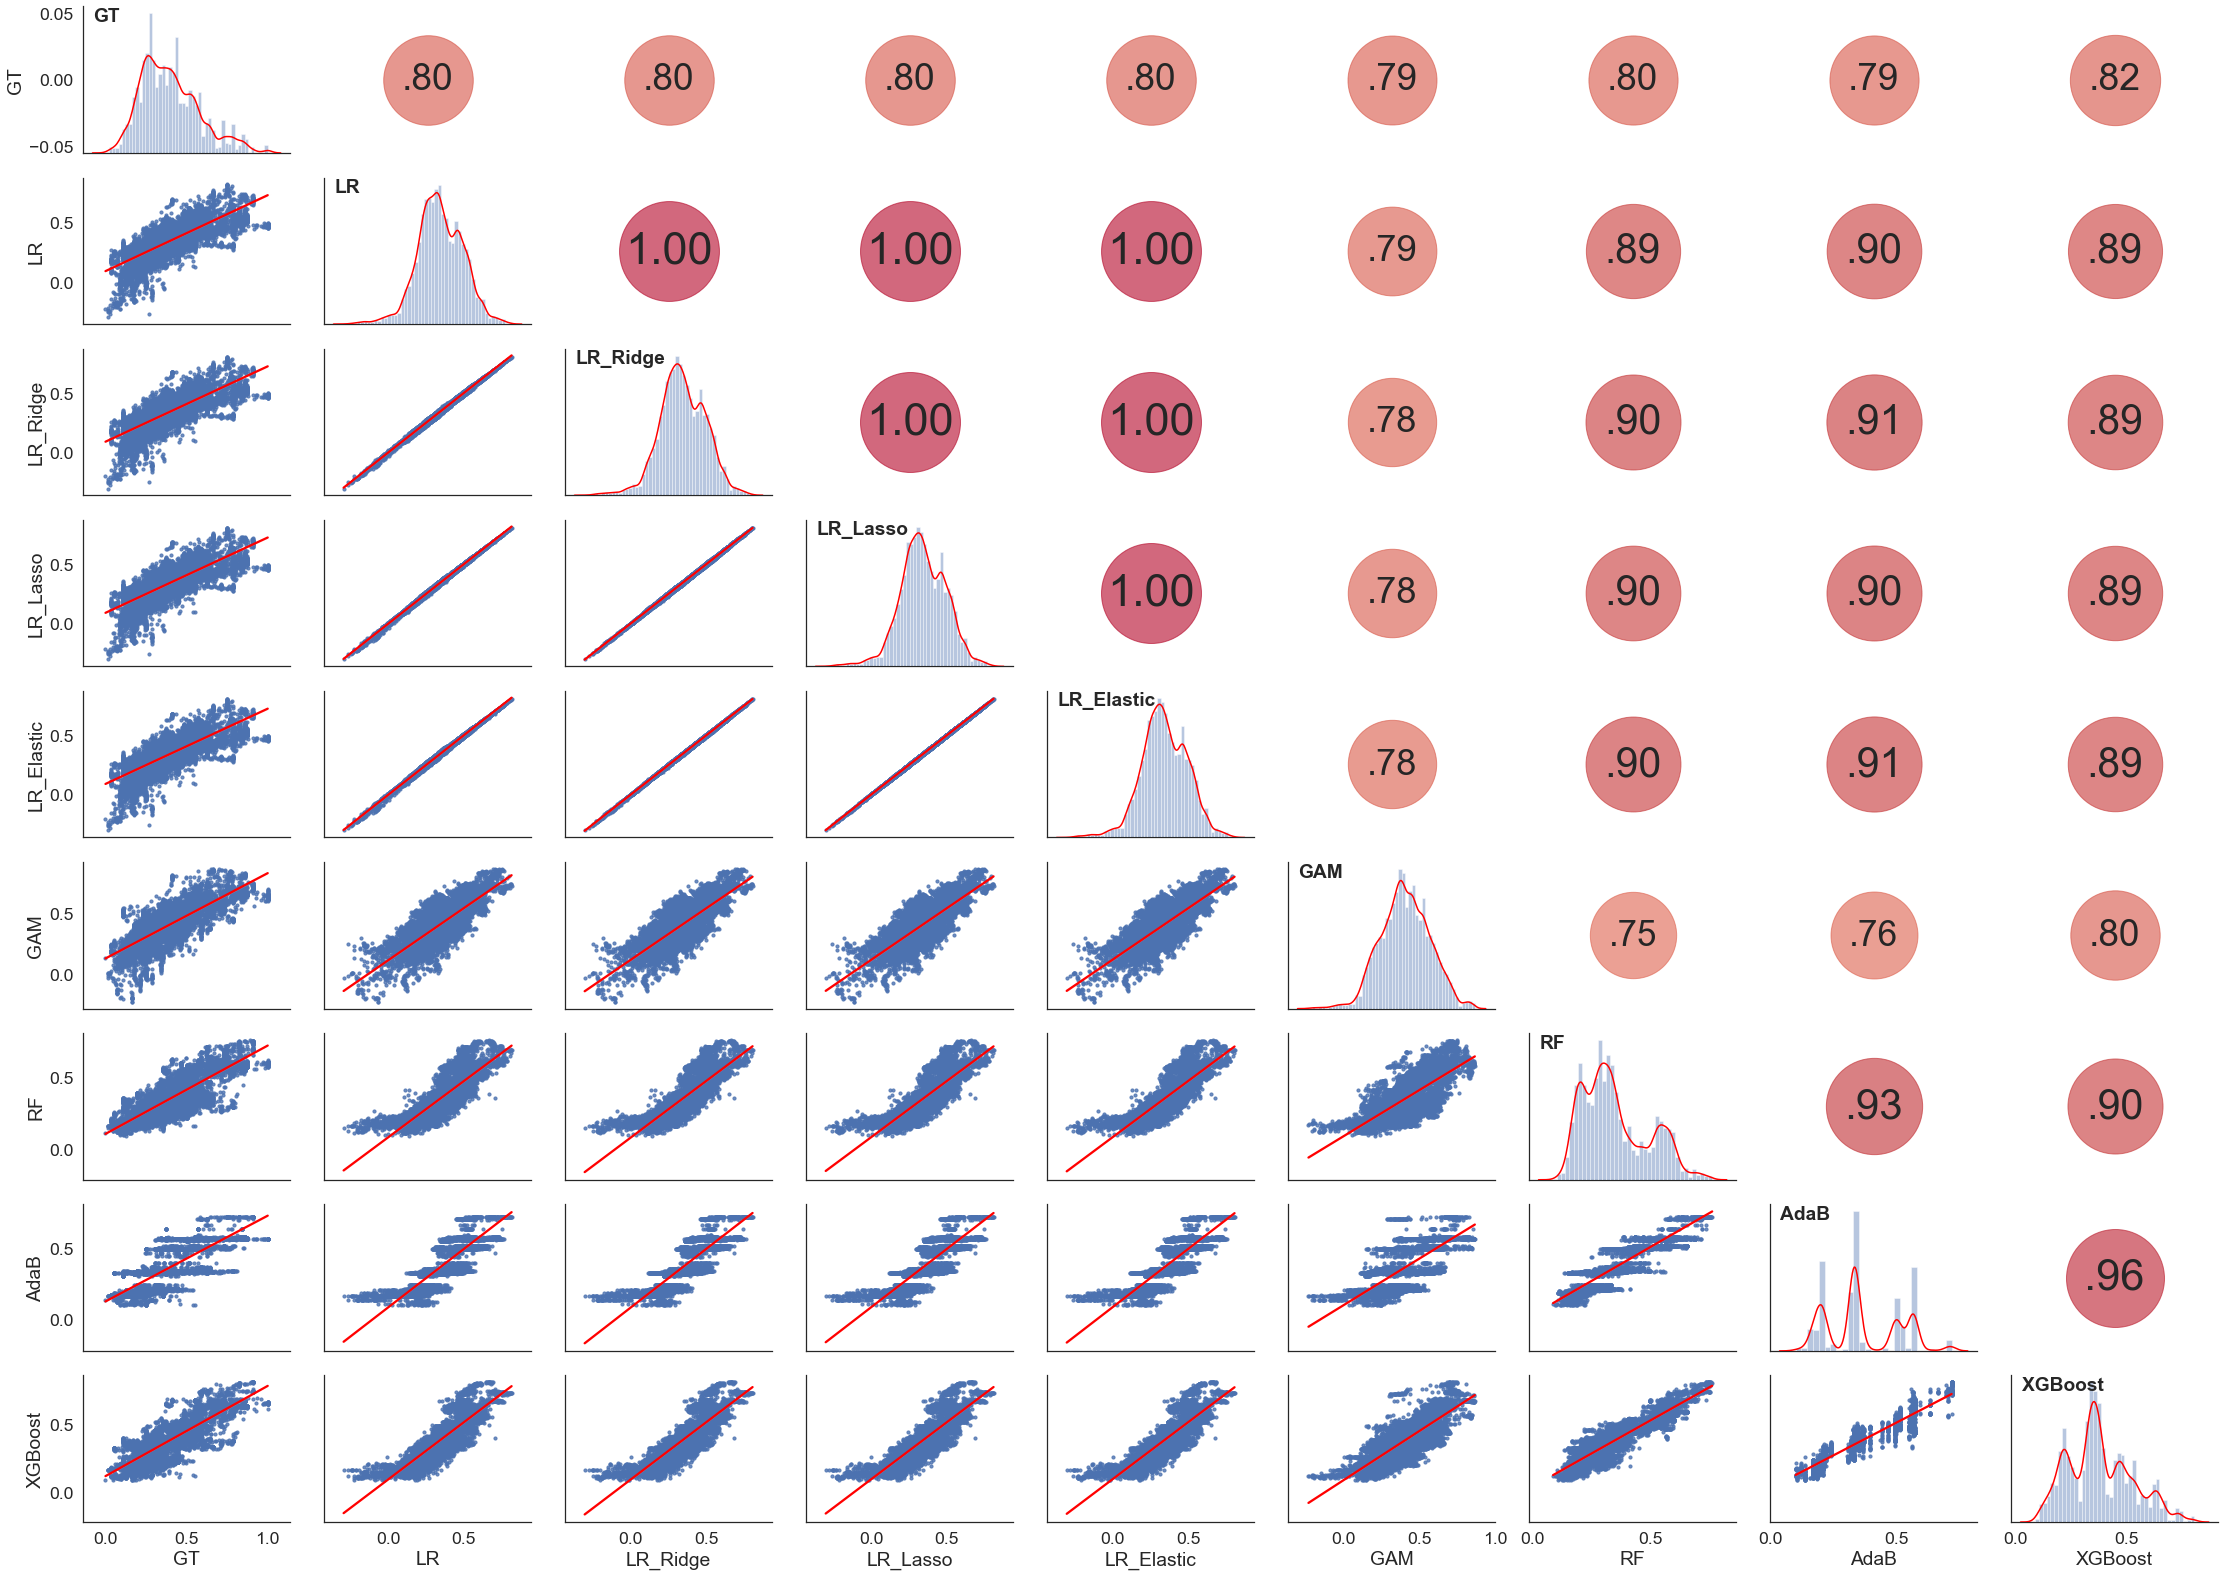

In [39]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
plt.figure()
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(preds, aspect=1.4, diag_sharey=False)
#g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'red'})
g.map_lower(sns.regplot, scatter_kws={'s':10}, line_kws={'color': 'red'})
g.map_diag(sns.distplot, kde_kws={'color': 'red'})
g.map_diag(annotate_colname)
g.map_upper(corrdot)

plt.savefig(output_path + 'Plots/scatter_corr')